# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Подгрузка используемых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# криминала не было и я убрал warnings
pd.options.display.max_colwidth = 150
import warnings
warnings.filterwarnings('ignore')

### Общая информация о предоставленных данных. 

Загрузка данных из csv-файла в датафрейм c помощью библиотеки pandas

In [3]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep = '\t')

Общая информация о полученных данных:

In [4]:
size_of_data = data.shape[0]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

1) Таблица состоит из 22 столбцов;
2) Общее количество объектов недвижимости 23699.

На всякий случай выполним проверку на наличие дубликатов.

In [5]:
data.duplicated().sum()

0

Дубликатов нет

Интересная вещь, что могут быть повторные попытки/продажи одного и того же объекта недвижимости.

In [6]:
impt_feat = ['total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'locality_name']
data.duplicated(subset=impt_feat).sum()

65

То есть как минимум 65 объектов в той или иной степенью успешности пытались продать несколько раз. Для удаленных от Санкт-Петербурга скорее безуспешно.

Проверим количество NaN в каждом столбце и суммарное количество строк с недостаточным числом данных.

In [7]:
missing_data = data.isna()
before = {'before': [(missing_data.any(axis=1).sum()), missing_data.sum().sum(),
                      missing_data.sum().sum()/data.shape[0]/data.shape[1], missing_data.any(axis=1).sum()/data.shape[0]]}
missing_stat = pd.DataFrame(before, index=['Количество неполностью заполненных строк', 'Общее количество пропусков', 'Доля пропусков к общему числу ячеек', 
                                           'Доля неполностью заполненных строк к общему их числу'])
print (f'Недостаточное количество данных по столбцам : \n{missing_data.sum()}')
missing_stat

Недостаточное количество данных по столбцам : 
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


,before
Количество неполностью заполненных строк,23449.000000
Общее количество пропусков,101441.000000
Доля пропусков к общему числу ячеек,0.194563
Доля неполностью заполненных строк к общему их числу,0.989451


,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


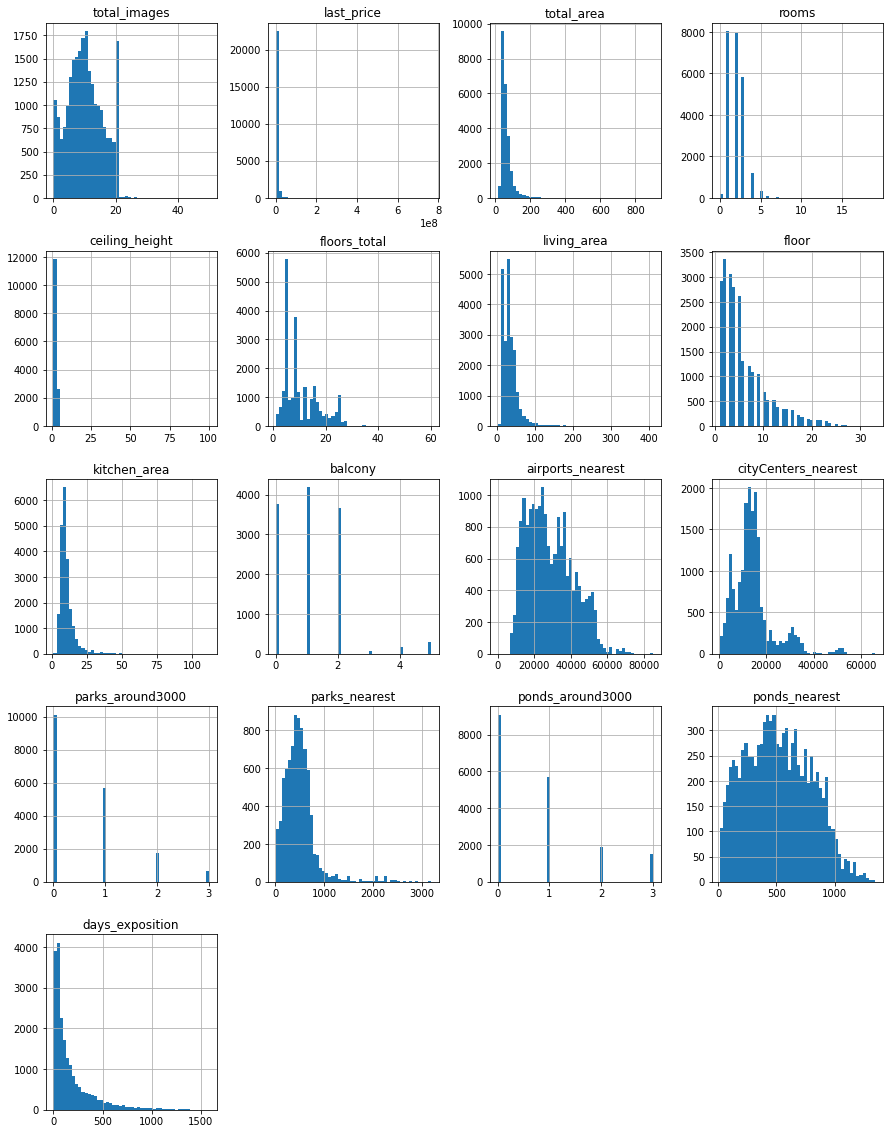

In [8]:
data.hist(bins = 50, figsize=(15, 20))
data.describe().loc[['mean', '50%', 'std', '75%', 'max']]

In [9]:
cols = data.select_dtypes(['float']).columns.values
cols

array(['last_price', 'total_area', 'ceiling_height', 'floors_total',
       'living_area', 'kitchen_area', 'balcony', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype=object)

**На основании оценки необработанных данных, можно следать следующие выводы:**
-  данные в стоблцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition представлены не для всех объектов недвижимости и могут потребовать дополнительной обработки для проведения анализа.
- практически для 99 % объектов недвижимости, имеются пропуски в данных, однако необходимо оценить значимость пропущенных данных и возможность их заполнить на стадии предобработки;
- данные в столбцах first_day_exposition, is_apartment, locality_name не являются числовыми или булевыми, то есть могут содержать строковые переменные либо быть неправильно форматированными (требует дальнейшей проверки);
- "total_images", "rooms", "floor", "balcony", "parks_around3000", "ponds_around3000", "floors_total", "citycenters_nearest", "parks_nearest", "ponds_nearest", "days_exposition" принимают целочисленные значения;
- last_price, total_area, rooms, ceiling_height, floors_total, living_area, kitchen_area, cityCenters_nearest, parks_nearest имеют большие выбросы и требуют дальнейшего исследования.

### Предобработка данных

**0.2.1 Обработка данных исходной таблицы:**

Сделаем все символы в названиях столбцов прописными

In [10]:
data.columns = data.columns.str.lower()

Переведем данным о дате начала продажи квартиры в формат времени:

In [11]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Для удобства будем считать цену квартир в тысячах рублей.

In [12]:
data['last_price'] = data['last_price']*1e-3

**0.2.2 Устранение неявных дубликатов в названиях населенных пунктов:**

Ячейки таблицы где возможен развернутый ответ(в формате строковых переменных), обычно содержат неявные дубликаты. Необходимо выполнить соответствующую проверку.

In [13]:
print('Количество уникальных названий: ', len(data['locality_name'].unique()))

Количество уникальных названий:  365


Уберем возможные дублирования 'е' и 'ё', сократим стандартные названия до аббревиатур (верхний нижний регистр, я проверил отдельно и в проект не включил..... с большой буквы смотриться лучше)

In [14]:
data['locality_name'] = (
     data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок'], 'п.г.т.', regex=True)
    .replace(['поселок при железнодорожной станции', 'поселок станции'], 'п. станции', regex=True)
    .replace(['садоводческое некоммерческое товарищество'], 'с.н.т.', regex=True)
    .replace(['садовое товарищество'], 'с.т.', regex=True)
    .replace(['коттеджный поселок'], 'к.п.', regex=True)
    .replace(['поселок'], 'п.', regex=True)
    .replace(['деревня'], 'д.', regex=True)
    .replace(['село'], 'с.', regex=True)
) 
print('Количество уникальных названий: ', len(data['locality_name'].unique()))

Количество уникальных названий:  322


Таким образом удалось объединить 43 месторасположения

**0.2.3 Изучение пропущенных значений в столбцах:**

**Здесь возможно два варианта:**
- когда значение не было заполнено, на основании отсутствия данного признака для объекта недвижимости: например, если балкона нет, но вероятно ячейка будет содержать NaN или 0;
- когда значение не заполнено и нет очевидных вариантов его определения. В таком случае можно оставить NaN или попытаться выполнить заполнение на основании средней величины. Оба варианта имеют свои достоинства и недостатки, определяемые дальнейшей обрабаткой данных. При корреляционном анализе, наверное можно данные не заполнять, оставив NaN - тем самым не увеличивая значимость средних значений, но как я слышал, говорят для более сложных исследований с использованием моделей машинного обучения NaN могут вызвать ошибки, и как раз заполнение среднии значениями является самым консервативным методом, позволяющим минимизировать влияние на итоговый результат.

Исходные данные для предобработки

In [15]:
print(data.isna().sum()[data.isna().sum() != 0])
data[data.columns[data.isna().sum() != 0]].head(5)

ceiling_height          9195
floors_total              86
living_area             1903
is_apartment           20924
kitchen_area            2278
balcony                11519
locality_name             49
airports_nearest        5542
citycenters_nearest     5519
parks_around3000        5518
parks_nearest          15620
ponds_around3000        5518
ponds_nearest          14589
days_exposition         3181
dtype: int64


,ceiling_height,floors_total,living_area,is_apartment,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,2.70,16.0,51.0,NaN,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,NaN,11.0,18.6,NaN,11.0,2.0,п. Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,NaN,5.0,34.3,NaN,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,NaN,14.0,NaN,NaN,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,3.03,14.0,32.0,NaN,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Пропущенные значения присутствуют в следующих столбцах и нуждаются в изучении:**  ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition


**Столбец "is_apartment"**

In [16]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Столбец содержит информацию - является ли объект недвижимости апартаментами. Скорее всего, для случая когда это все таки квартира, продавец просто не указывал значение в столбце. Здесь целесообразно NaN заменить на False.

In [17]:
data['is_apartment'].fillna(False, inplace=True);

**Столбец "balcony"**

In [18]:
data['balcony'].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Столбец содержит информацию о количестве балконов. Скорее всего продавец не указывал значение в столбце, когда балконов нет. Здесь целесообразно NaN заменить на 0.

In [19]:
data['balcony'].fillna(0, inplace=True);

**Столбцы "parks_around3000" и parks_nearest**

1. Отсутствие значения в столбце "parks_nearest" говорит о том, что скорее всего парков в округе нет и тогда значения NaN в столбце "parks_around3000" можно заполнить 0

In [20]:
print ("Количество ячеек parks_around3000 для заполнения 0:",  data[(data['parks_nearest'].isnull())&(data['parks_around3000'].isnull())].shape[0])

Количество ячеек parks_around3000 для заполнения 0: 5518


In [21]:
data.loc[(data['parks_nearest'].isnull())&(data['parks_around3000'].isnull()),'parks_around3000']= 0

Интересно, что таким образом удалось полностью заполнить столбец 'parks_around3000'

In [22]:
print ("Количество ячеек parks_around3000 для заполнения 0:",  data[(data['parks_nearest'].isnull())&(data['parks_around3000'].isnull())].shape[0])

Количество ячеек parks_around3000 для заполнения 0: 0


На всякий случай проверим случам когда указано расстояние до парка больше 3 км

In [23]:
data['parks_around3000'][data['parks_nearest']>3000]

1590     0.0
10959    0.0
19208    0.0
19430    0.0
Name: parks_around3000, dtype: float64

Все хорошо, тут 0

2. В обратном направлении, где требуется указать конкретное расстояние, такой подход не сработает, по-этому оставим значения в столбце "parks_nearest" - NaN. Можно определить по столбцу 'parks_around3000' где парков нет, однако вопрос какими значениям заполнить, сложный и скорее всего необходимо создавать отдельный категориальный столбец с разбивкой по расстояниям и уже в нем пытаться обыграть эти данные.

**Столбцы "ponds_around3000" и "ponds_nearest"**

Та же самая ситуация, что и ранее с парками (можно было б сделать функцию, но для двух использований тут не так много вычислений)

In [24]:
print ("Количество ячеек parks_around3000 для заполнения 0:",  data[(data['ponds_nearest'].isnull())&(data['ponds_around3000'].isnull())].shape[0])

Количество ячеек parks_around3000 для заполнения 0: 5518


In [25]:
data.loc[(data['ponds_nearest'].isnull())&(data['ponds_around3000'].isnull()), 'ponds_around3000']= 0

Удалось полностью заполнить столбец 'ponds_around3000'

На всякий случай проверим случам когда указано расстояние до пруда больше 3 км

In [26]:
data['ponds_around3000'][data['ponds_nearest']>3000]

Series([], Name: ponds_around3000, dtype: float64)

Таким значений нет

**Столбец "floors_total"**

Для заполнения пропусков в этажности зданий, возможно использовать следующее: 1) высота застройки зависит от населенного пункта (нецелесообразно для заполнения пропусков использовать общее медианное значение); 2) необходимо проконтролировать, чтобы при полученной средней этажности, конкретный этаж помещения был не выше. Если использовать отношение "среднее значение этажа/средную этажность здания", это может привести к росту этажности для случаев высокого расположения объектов недвижимости в доме и соответственно необоснованному увеличению разброса этажности зданий. Поэтому будем брать средную этажность по населенному пункту и если конкретный этаж будет выше или равен этажности, заменять ее на "этаж" + 1. Добавление единицы позволит сохранить долю квартир на последнем этаже, которая влияет на стоимость квадратного места; 3) Для случая когда не определен населенный пункт, определять значение этажности не будем.

In [27]:
list_items = data[data['floors_total'].isnull()]['locality_name'].unique()
list_items

array(['Санкт-Петербург', 'Кудрово', 'п. Щеглово', 'п. Бугры',
       'п. Мурино', nan, 'п.г.т. Новоселье', 'Красное Село', 'п. Шушары',
       'п.г.т. Токсово', 'д. Новое Девяткино', 'п. Стрельна'],
      dtype=object)

In [28]:
for item in  list_items:
    if item == item:
        av_tot_fl = data.query('locality_name == @item')['floors_total'].median()
        data.loc[(data['floors_total'].isnull()) & (data['locality_name']==item) & (data['floor'] >=av_tot_fl-1), 'floors_total'] = data['floor']+1
        data.loc[(data['floors_total'].isnull()) & (data['locality_name']==item), 'floors_total']= av_tot_fl             

In [29]:
data[data['floors_total'].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8986,10,4850.0,103.1,2018-07-10,3,NaN,NaN,68.1,4,False,...,16.7,0.0,NaN,19659.0,31813.0,0.0,NaN,0.0,NaN,28.0


Вообще можно прикинуть по расположению относительно аэропорта и центра города, в каком населенном пункте находится эта квартира

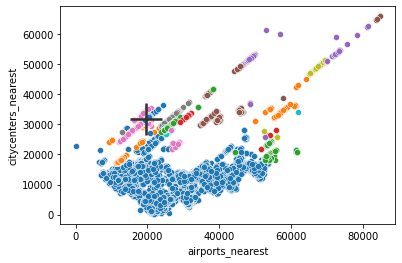

In [30]:
for city in data['locality_name'].unique():
    sns.scatterplot(
        x='airports_nearest', 
        y='citycenters_nearest', 
        data=data.query('locality_name == @city'),
        );
sns.scatterplot(
    x='airports_nearest', 
    y='citycenters_nearest', 
    data=data[data['floors_total'].isnull()],
    s=1000, color=".2", marker="+"
);
#plt.xlim(0.8*data[data['floors_total'].isnull()]['airports_nearest'].values, 1.2*data[data['floors_total'].isnull()]['airports_nearest'].values);
#plt.ylim(0.8*data[data['floors_total'].isnull()]['citycenters_nearest'].values, 1.2*data[data['floors_total'].isnull()]['citycenters_nearest'].values);

Вероятнее всего в одном из обособленных районов Санкт-Петербурга, но из-за одного значения продолжать исследование в этом направлении мы не будем )))

**Столбец "airports_nearest"**

Для заполнения пропусков будем использовать схожую логику как и в случае "floors_total", только исключим из рассмотрения случае, где для населенных пунктов не было указано ни одно расстояние до аэропорта

In [31]:
data[data['airports_nearest'].isnull()].shape[0]

5542

In [32]:
list_items = data[data['airports_nearest'].isnull()]['locality_name'].unique()

In [33]:
for item in  list_items:
    if  item == item  and  ~data.loc[data['locality_name']==item, 'airports_nearest'].isnull().values.all(axis=0):
        av_arp_dist = data.query('locality_name == @item')['airports_nearest'].median()
        data.loc[(data['airports_nearest'].isnull()) & (data['locality_name']==item), 'airports_nearest']=  av_arp_dist 

In [34]:
data[data['airports_nearest'].isnull()].shape[0]

4872

Таким образом удалось уменьшить ячейки с NaN на 670. В остальных случаях, в населенных пунктах не было указано расстояние до аэропорта для всех объектов.

**Столбец "citycenters_nearest"**

Для заполнения пропусков будем использовать схожую логику как и в случае "airports_nearest", добавим условие, что это будет не Санкт-Петербург. Вероятно город большой со множеством районов и столбец характеризует расстояние именно до его центра.

In [35]:
data[data['citycenters_nearest'].isnull()].shape[0]

5519

In [36]:
list_items = data[data['citycenters_nearest'].isnull()]['locality_name'].unique()

In [37]:
for item in  list_items:
    if  item == item  and  ~data.loc[(data['locality_name']==item) & (data['locality_name']!='Санкт-Петербург') , 'citycenters_nearest'].isnull().values.all(axis=0):
        av_city_dist = data.query('locality_name == @item')['citycenters_nearest'].median()
        data.loc[(data['citycenters_nearest'].isnull()) & (data['locality_name']==item), 'citycenters_nearest']=  av_city_dist 

In [38]:
data[data['citycenters_nearest'].isnull()].shape[0]

4933

Таким образом удалось уменьшить ячейки с NaN на 586. В остальных случаях, в населенных пунктах не было указано расстояние до центра города для всех объектов или это был Санкт-Петербург

**Столбец "days_exposition"**

Оценим, сколько вообще незаполеннных ячеек

In [39]:
data[data['days_exposition'].isnull()].shape[0]

3181

Пропуски означают, что квартира не продана, соответственно заполнять их не следует, можно просто конвертировать значения в стоблце в целочисленный формат.

In [40]:
data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int32')

In [41]:
data['days_exposition'].dtypes

Int32Dtype()

**Столбец "ceiling_height"**

Высота потолка зависит вероятно от времени постройки дома и к чему-то привязаться, из имеющихся данных, не получится. Либо оставить как есть, либо заполнить средними значениями. 

In [42]:
ceiling_av= data['ceiling_height'].median()
ceiling_av

2.65

In [43]:
data[data['ceiling_height'].isnull()].shape[0]

9195

In [44]:
data.loc[data['ceiling_height'].isnull(), 'ceiling_height'] = ceiling_av

In [45]:
data[data['ceiling_height'].isnull()].shape[0]

0

**Столбцы "living_area", "kitchen_area" и 'studio'** 

При заполнении данных столбцов будет важно зазделять, квартиры и студии. Под студией будем понимать квартиру с кухней объединенной с комнатой. В данных есть несколько квартир, для которых количество комнат равно 0, при этом она не является студией и обратная ситуация, когда комнат 0, 1 и квартира является студией. Второй случай видимо больше зависит от специфических особенностей планировки, а вот для первого случая, целесообразно внести исправления в столбец "studio".

In [46]:
data[(data['rooms']==0) & (data['studio']==False)].shape[0]

59

In [47]:
data.loc[data['rooms']==0, 'studio'] = 1
data[(data['rooms']==0) & (data['studio']==False)].shape[0]

0

 - Под "жилой площадью" понимают суммарную площадь комнат, тут лучше всего определять исходя из среднего размер для n-комнатных квартир. Отдельно можно посчитать жилую площадь для квартир-студий (кухня объединена с комнатой и количество комнату практически везде равно 0)
 - Для площади кухни можно придерживаться такой же логики.

Тогда можно будет создать функцию, так как операции подобны:

In [48]:
print('Количество пропущенных значений для жилой площади:', data[data['living_area'].isnull()].shape[0])
print('Количество пропущенных значений для площади кухни:', data[data['kitchen_area'].isnull()].shape[0])

Количество пропущенных значений для жилой площади: 1903
Количество пропущенных значений для площади кухни: 2278


In [49]:
def area_filling (data, column_name):
    area_pt = pd.pivot_table(data, index=["studio", "rooms"], values = column_name, aggfunc = ['median']).reset_index()
    area_pt.columns = ['studio', 'rooms', 'median']
    result = pd.merge(data[["studio", "rooms", column_name]], area_pt, on=["studio", "rooms"], how= 'left')
    data.loc[data[column_name].isnull(), column_name] = result['median']

In [50]:
area_filling (data, 'living_area')
area_filling (data, 'kitchen_area')

In [51]:
print('Количество пропущенных значений для жилой площади:', data[data['living_area'].isnull()].shape[0])
print('Количество пропущенных значений для площади кухни:', data[data['kitchen_area'].isnull()].shape[0])

Количество пропущенных значений для жилой площади: 0
Количество пропущенных значений для площади кухни: 208


Незаполненные значения объясняются тем, что остались незаполненные ячейки для квартир-студий, где кухонь нет.

**0.2.4 Результаты предварительной обработки:**

Изменим тип данных, где это стало возможным

In [52]:
data['studio']=data['studio'].astype(bool);
data['balcony']=data['balcony'].astype(int);
data['parks_around3000']=data['parks_around3000'].astype(int);
data['ponds_around3000']=data['ponds_around3000'].astype(int);

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23698 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23491 non-null  float64       
 13  balcony         

In [54]:
missing_data = data.isna()
print (f'Недостаточное количество данных по столбцам : \n{missing_data.sum()}')
missing_data = data.isna()
after = [(missing_data.any(axis=1).sum()), missing_data.sum().sum(),
          missing_data.sum().sum()/data.shape[0]/data.shape[1], missing_data.any(axis=1).sum()/data.shape[0]]
missing_stat['after'] = after
missing_stat

Недостаточное количество данных по столбцам : 
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                1
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              208
balcony                     0
locality_name              49
airports_nearest         4872
citycenters_nearest      4933
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64


,before,after
Количество неполностью заполненных строк,23449.000000,19605.000000
Общее количество пропусков,101441.000000,43453.000000
Доля пропусков к общему числу ячеек,0.194563,0.083343
Доля неполностью заполненных строк к общему их числу,0.989451,0.827250


1. Использование правильных типов данных позволило несколько сократить размер таблицы: было 3.7+ MB, а стало 3.2+ MB;
2. Удалось сократить общее число пропусков с 19.4 % до 0.08 %;
3. Основные пропуски сосредоточены в столбцах связанных с географией объектов недвижимости: расстояние до парка/пруда, расстояние до центра города/аэропорта;
4. В основном, пропуски в расстоянии до парка/пруда связаны с отсутствием обозначенных объектов и их заполнение не требуется;
5. В основном, пропуски в расстоянии до центра города/аэропорта, определяются неактуальностью данной информации ввиду значительной удаленности объекта недвижимости, что не оказывает влияние на конечную стоимость;
6. Пропуски в days_exposition характерны для конкретных населенных пунктов в целом - это вопрос скорее в тем, что предоставил таблицу;
7. Пропуски в locality_name могут быть заполнены на основании географических данных и еще каких либо параметров(требует дополнительного исследования), но их немного и в данной работе предлагаю их не трогать;
8. Значения NaN в kitchen_area соответствуют квартирам-студиях;
9. Одно значение не заполнено в графе floors_total, потому что для заполнения использовалась привязка к конкретному населенному пункту, а в данном случае и эта ячейка была NaN.

### Добавление в таблицу новых столбцов в соответствии с заданием

**0.3.1 Цена одного квадратного метра:**

In [55]:
data['price_per_meter'] = data['last_price']/data['total_area']

**0.3.2 День недели публикации объявления:**

In [56]:
data['day_of_publication'] = data['first_day_exposition'].dt.dayofweek

**0.3.3 Месяц публикации объявления:**

In [57]:
data['month_of_publication'] = data['first_day_exposition'].dt.month

**0.3.4 Год публикации объявления:**

In [58]:
data['year_of_publication'] = data['first_day_exposition'].dt.year

**0.3.5 Tип этажа квартиры:**

In [59]:
def floor_to_cat (row):
    if row['floor']/row['floors_total'] == 1:
        return 'last'
    elif row['floor']==1:
        return 'first'    
    elif row['floor']==row['floor']:                 # там где то затесался NaN 
        return 'other'

In [60]:
data['type_of_floor'] = data.apply(floor_to_cat, axis=1)

Чтобы в дальнейшем исследовать корреляции(с помощью heatmap и scatter plot), наверное стоит сделать еще один столбец с числовыми значениями признака этажности [0 , 1 , 2]

In [61]:
def floor_to_cat_num (row):
    if row['floor']/row['floors_total'] == 1:
        return 2
    elif row['floor']==1:
        return 0    
    elif row['floor']==row['floor']:                 # там где то затесался NaN 
        return 1

In [62]:
data['type_of_floor_num'] = data.apply(floor_to_cat_num, axis=1)

**0.3.6 Расстояние до центра города в километрах(переведите из м в км и округлите до ближайших целых значений):**

In [63]:
data['center_city_dist_in_km'] = (data['citycenters_nearest']*1e-3).round()

**0.3.7 Итоговая таблица:**

In [64]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_publication,month_of_publication,year_of_publication,type_of_floor,type_of_floor_num,center_city_dist_in_km
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2,755.0,<NA>,120.370370,3,3,2019,other,1,16.0
1,7,3350.0,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,0,NaN,81,82.920792,1,12,2018,first,0,19.0
2,10,5196.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,2,574.0,558,92.785714,3,8,2015,other,1,14.0
3,0,64900.0,159.0,2015-07-24,3,2.65,14.0,45.0,9,False,...,3,234.0,424,408.176101,4,7,2015,other,1,7.0
4,2,10000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1,48.0,121,100.000000,1,6,2018,other,1,8.0


### Проведите исследовательский анализ данных

**0.4.1 Изучить и обработать аномалии для: "total_area", "living_area", "kitchen_area", "last_price", "rooms", "ceiling_height", "type_of_floor", "floors_total", "citycenters_nearest", "parks_nearest" (по заданию)**

**Столбец "total_area"** 

In [65]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Квартиры с 12 кв. метрами бывают. Поэтому можно посмотреть, что происходит в районе 250+ кв. метров

In [66]:
data.loc[(data['total_area']>250)].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_publication,month_of_publication,year_of_publication,type_of_floor,type_of_floor_num,center_city_dist_in_km
155,8,96000.0,317.0,2017-07-07,4,3.50,3.0,183.0,3,False,...,3,366.0,62,302.839117,4,7,2017,last,2,2.0
464,15,66571.0,280.3,2015-06-11,6,5.20,8.0,159.5,7,False,...,1,616.0,578,237.499108,3,6,2015,other,1,7.0
581,20,65000.0,365.0,2019-03-18,7,2.90,7.0,145.0,7,False,...,3,58.0,<NA>,178.082192,0,3,2019,last,2,2.0
660,3,49950.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,False,...,3,22.0,391,103.223807,2,10,2017,other,1,1.0
793,20,135000.0,310.0,2018-05-22,4,3.30,5.0,250.0,2,False,...,3,190.0,342,435.483871,1,5,2018,other,1,7.0
866,5,25000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,False,...,2,435.0,418,68.870523,5,12,2017,other,1,8.0
1026,20,155000.0,310.0,2018-10-12,5,5.30,3.0,190.0,3,False,...,1,603.0,<NA>,500.000000,4,10,2018,last,2,5.0
1085,16,75000.0,323.0,2017-07-10,5,4.00,5.0,255.7,4,False,...,2,515.0,259,232.198142,0,7,2017,other,1,1.0
1188,20,118000.0,290.6,2018-06-01,6,3.82,6.0,188.7,3,False,...,0,NaN,316,406.056435,4,6,2018,other,1,6.0
1300,14,120000.0,280.0,2018-07-12,5,4.70,4.0,162.0,3,False,...,3,339.0,225,428.571429,3,7,2018,other,1,4.0


Ничего прям чтобы уж очень сверхестественного тут нет, с точки зрения аномалий. Единственное, что следует сделать - сравнить стоимость квадратного метра, со средней стоимостью квадратного метра

In [67]:
print('Средняя цена квадратного метра:', data['price_per_meter'].median(), 'тыс. рублей')
print ('Квартиры со стоимостью квадратного метра ниже среднего значения:',data.loc[(data['total_area']>250)&(data['price_per_meter']<=data['price_per_meter'].median())].shape[0])
print('Квартиры со стоимостью квадратного метра выше среднего значения:', data.loc[(data['total_area']>250)&(data['price_per_meter']>data['price_per_meter'].median())].shape[0])


Средняя цена квадратного метра: 95.0 тыс. рублей
Квартиры со стоимостью квадратного метра ниже среднего значения: 30
Квартиры со стоимостью квадратного метра выше среднего значения: 82


Где-то у 30% процентов объектов недвижимости(площадью выше 250 кв.метров), цена квадратного метра ниже......... это странно. Так как квартиры должны быть "элитными". Но и это само по себе не является причиной для их отсеивания

С точки зрения отсеивания выбросов, максимальное значение площади квартиры составляет 900 кв. метров. Что находится далеко за значениями третьего квартиля(таблица выше). Для определения выбросов используем метод межквартильного интервала, z-scope метод  и про процентилю (0.975). Так как будут исследоваться несколько величин, целесообразно написать соответствующую функцию:

In [68]:
def outliers_method (data, column_name, labl):
    # iqr,  percentiles, z-score methods for labl
    # возвращает верхнюю границу выборки
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    Q_proc = data[column_name].quantile(0.975)
    data['z_score'] = (data[column_name] - data[column_name].mean())/data[column_name].std()
    z_max = data.loc[data['z_score']<3, column_name].max()
    IQR = Q3 - Q1
    upper_lim = Q3 + 1.5*IQR
    lower_lim = Q1 - 1.5*IQR
    interv = np.arange(0,upper_lim)
    parts = data[(data[column_name] > upper_lim)]
    parts_proc = data[(data[column_name] > Q_proc)]
    parts_z    = data[data['z_score']>=3]
    fig, (ax2, ax1) = plt.subplots(2, sharex=True,  figsize=(20, 5), gridspec_kw={"height_ratios": (.15, .85)})
    sns.histplot(data = data, x = column_name, bins=100, ax=ax1); 
    ax1.axvline(x = upper_lim, color = 'b', linestyle='dashed', label = 'Q3+1.5*IRQ')
    ax1.axvline(x = lower_lim, color = 'k', linestyle='dashed', label = 'Q1-1.5*IRQ')
    sns.boxplot(data = data, x=column_name,ax=ax2) 
    if labl  == 'iqr':
        fig.suptitle(column_name +': method IQR')
        ax1.axvspan(lower_lim, upper_lim, facecolor='g', alpha=0.1, label = 'Основные данные')
        ax1.axvspan(upper_lim, data[column_name].max(), facecolor='y', alpha=0.1, label = 'Выбросы')
        text = 'Доля выбросов к объему DataSet:   '+ str(round(parts.shape[0]/data.shape[0]*100, 2))+'%'
        ax1.text(0.6, 0.5, text, horizontalalignment='center',  verticalalignment='center', transform = ax1.transAxes)
        ax1.legend(loc='upper right')
        plt.show()
        return upper_lim
    elif labl == 'percentiles':
        fig.suptitle(column_name +': percentile method' +'(0.975)')
        ax1.axvspan(lower_lim, Q_proc, facecolor='g', alpha=0.1, label = 'Основные данные')
        ax1.axvspan(Q_proc, data[column_name].max(), facecolor='y', alpha=0.1, label = 'Выбросы')
        text = 'Доля выбросов к объему DataSet:   '+ str(round(parts_proc.shape[0]/data.shape[0]*100, 2))+'%'
        ax1.text(0.6, 0.5, text, horizontalalignment='center',  verticalalignment='center', transform = ax1.transAxes)
        ax1.legend(loc='upper right')
        plt.show()
        return Q_proc
    elif labl == 'z-score':
        fig.suptitle(column_name +': z-score method')
        ax1.axvspan(lower_lim, z_max, facecolor='g', alpha=0.1, label = 'Основные данные')
        ax1.axvspan(z_max, data[column_name].max(), facecolor='y', alpha=0.1, label = 'Выбросы')
        text = 'Доля выбросов к объему DataSet:   '+ str(round(parts_z.shape[0]/data.shape[0]*100, 2))+'%'
        ax1.text(0.75, 0.5, text, horizontalalignment='center',  verticalalignment='center', transform = ax1.transAxes)
        ax1.legend(loc='upper right')
        plt.show()
        return z_max

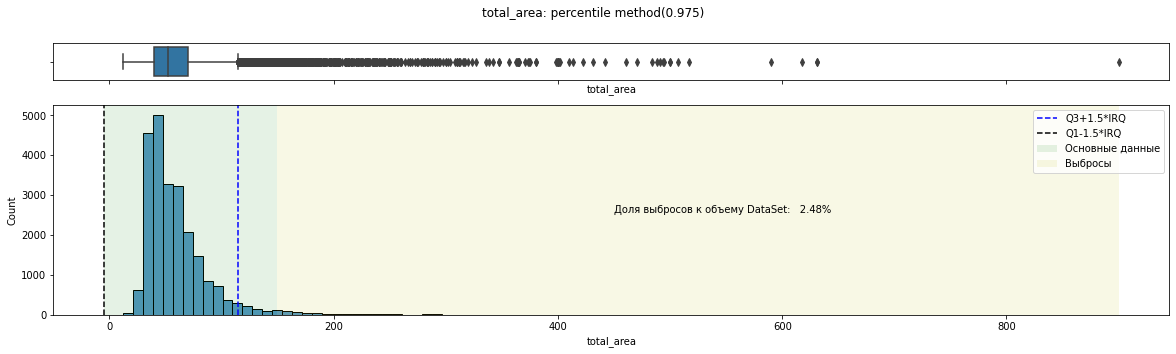

149.0


In [69]:
upper_lim_p = outliers_method(data, 'total_area', 'percentiles')
print(upper_lim_p)

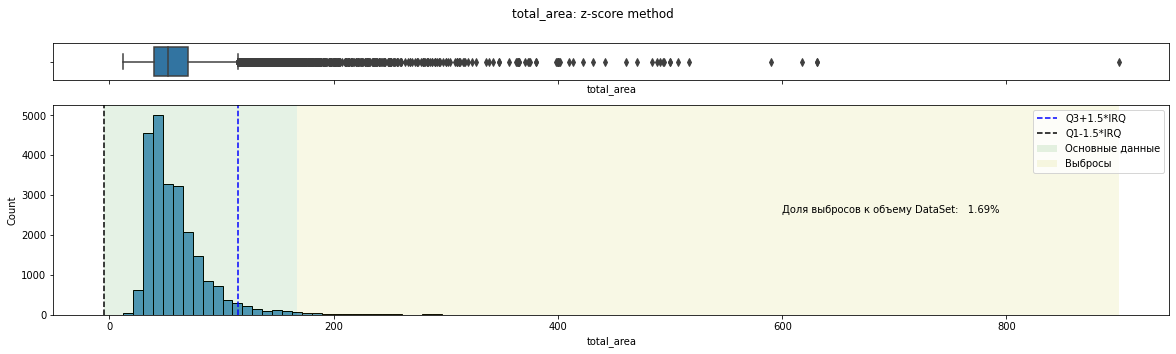

167.1


In [70]:
upper_lim_z = outliers_method(data, 'total_area', 'z-score')
print(upper_lim_z)

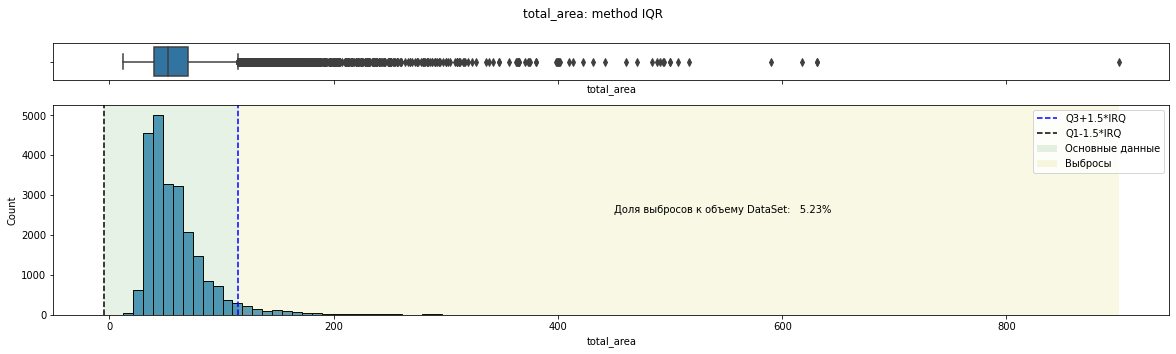

114.75000000000001


In [71]:
upper_lim_iqr = outliers_method(data, 'total_area', 'iqr')
print(upper_lim_iqr)

Посмотрим средний размер 4-комнатной квартиры:

In [72]:
data.loc[data['rooms']==4, 'price_per_meter'].median()

92.66666666666667

Квартиры большего размера обычно открытой планировки, и вероятно относятся к классу элитного жилья. По-этому вполне возможно воспользоваться методом IQR для выборки(и везде далее)

In [73]:
data = data[data['total_area']<=upper_lim_iqr]

In [74]:
data.shape[0]

22459

Потеряно около 5.23 % данных

**Столбец "living_area"** 

In [75]:
data['living_area'].describe()

count    22459.000000
mean        31.024467
std         13.490271
min          2.000000
25%         18.000000
50%         30.000000
75%         40.000000
max        145.000000
Name: living_area, dtype: float64

Отобразим выборку для площади меньше 18 кв.метров

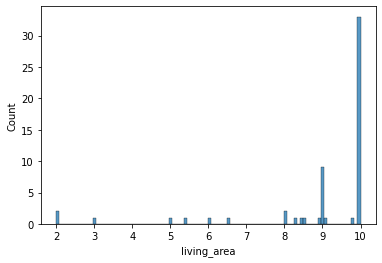

In [76]:
sns.histplot(data = data[data['living_area']<=10], x = 'living_area', bins=100); 

Похоже на то, что меньше 8 кв. метров это выброс. Добавим, что вообще средний размер комнаты не может быть меньше 8 кв. метров. Вообще....Согласно действующим СНиПам, минимальная площадь комнаты должна быть не менее 8 квадратных метров (п. 5.3 СП 5.413330.2011) 

In [77]:
data['area_per_room'] = data['living_area']/data['rooms']

In [78]:
data = data[(data['area_per_room']>=8) & (data['living_area']>=8)]

Отобразим выборку для площади больше 80 кв.метров

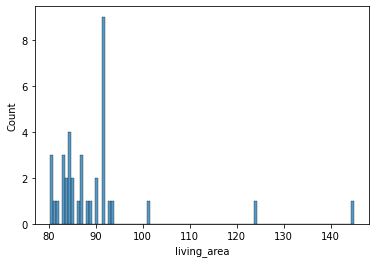

In [79]:
sns.histplot(data = data[data['living_area']>80], x = 'living_area', bins=100); 

Больше 100 это выбросы, но здесь лучше отсеить их на основании IQR метода

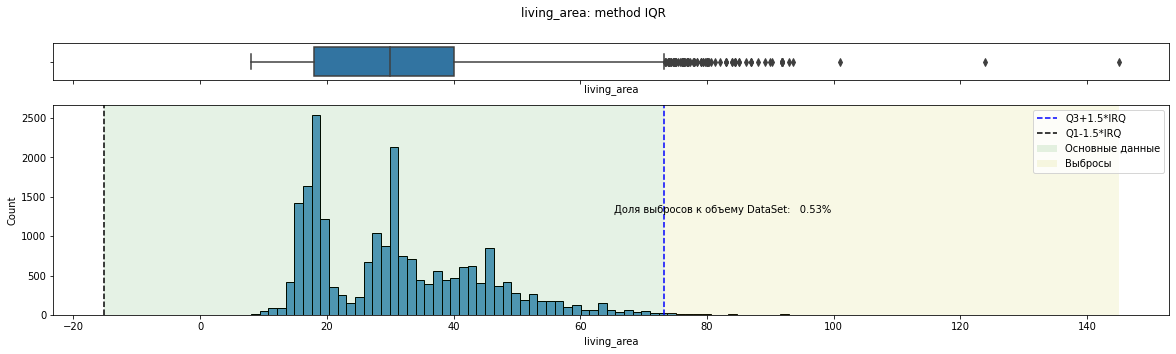

73.25


In [80]:
upper_lim_iqr = outliers_method(data, 'living_area', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_iqr)

Так как полученная доля выбросов меньше 0.5 %, не будем их исследовать, а просто отсеем.

In [81]:
data = data[data['living_area']<=upper_lim_iqr]

In [82]:
data.shape[0]

22287

**Столбец "kitchen_area"**

In [83]:
data['kitchen_area'].describe()

count    22082.000000
mean         9.811903
std          4.123071
min          1.300000
25%          7.100000
50%          9.000000
75%         11.000000
max         55.700000
Name: kitchen_area, dtype: float64

Отобразим выборку для площади меньше 5.5 кв.метров

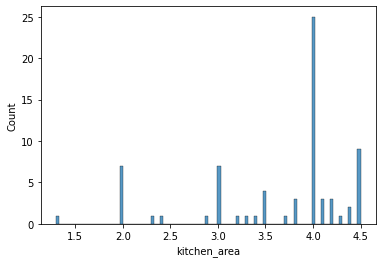

In [84]:
sns.histplot(data = data[data['kitchen_area']<=4.5], x = 'kitchen_area', bins=100); 

Я посмотрел, в yandex поиск, есть объявления "как обустроить кухни 3 кв.метра". Возможно это была квартира с открытой планировкой и т.п. Однако значения меньшей площади будет считать выбросом.

In [85]:
data = data[(data['kitchen_area']>=3)]

Отобразим выборку для площади больше 15 кв.метров

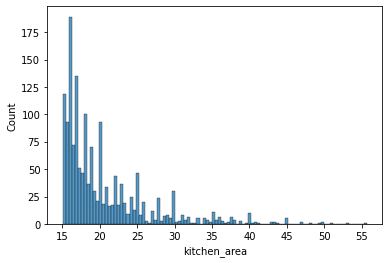

In [86]:
sns.histplot(data = data[data['kitchen_area']>15], x = 'kitchen_area', bins=100); 

Больше 30 скорее всего выбросы, но здесь лучше отсеить их на основании IQR метода

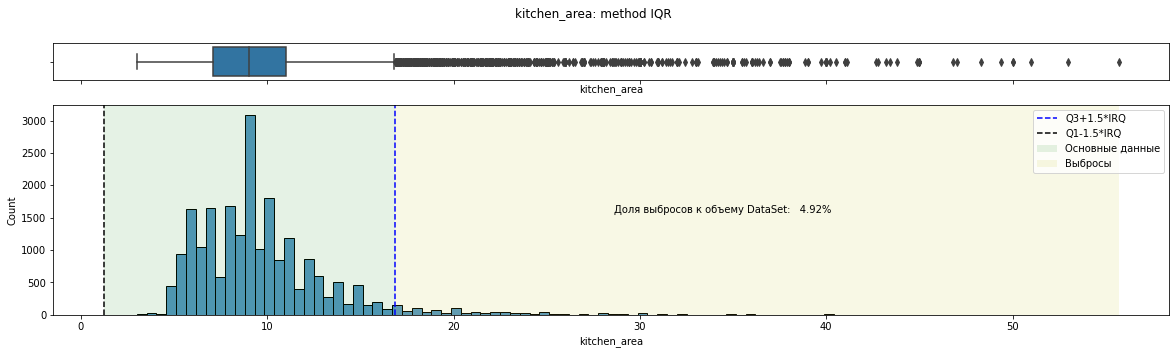

16.85


In [87]:
upper_lim_iqr = outliers_method(data, 'kitchen_area', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_iqr)

Получается слишком большой отсев порядка 5 %, попробуем более консервативно оставить 97.5% 

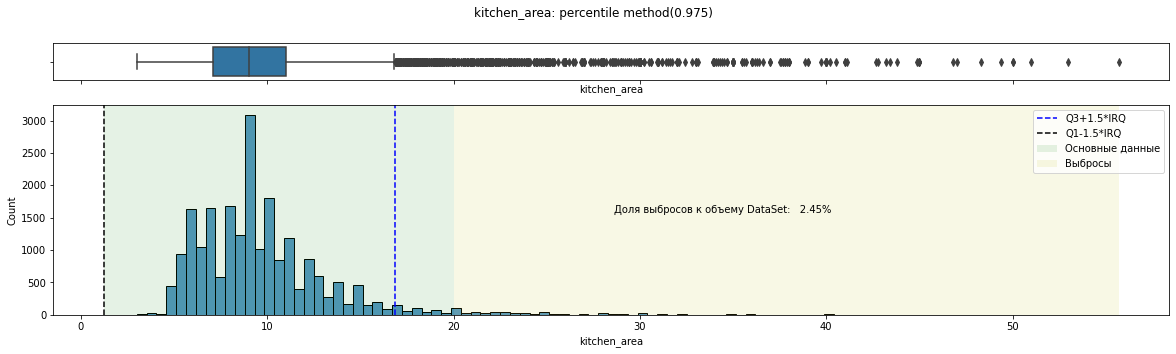

20.0


In [88]:
upper_lim_p = outliers_method(data, 'kitchen_area', 'percentiles') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

Получается отрезать "хвост" распределения начиная с области где сохранялась монотонность убывания количества кухонь.

In [89]:
data = data[data['kitchen_area']<=upper_lim_p]

In [90]:
data.shape[0]

21530

На текущий момент потеряно около 9.2 % данных

**Столбец "rooms"**

In [91]:
data['rooms'].describe()

count    21530.000000
mean         1.946307
std          0.873427
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

В принципе чего-то аномального здесь нет. Можно посмотреть строки с 6 комнатами в квартирах.

In [92]:
data[data['rooms']>5]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,price_per_meter,day_of_publication,month_of_publication,year_of_publication,type_of_floor,type_of_floor_num,center_city_dist_in_km,z_score,area_per_room
5255,15,6100.0,87.0,2017-06-28,6,3.50,3.0,68.0,2,False,...,<NA>,70.114943,2,6,2017,other,1,34.0,-0.950316,11.333333
9856,13,12000.0,106.0,2018-07-30,6,2.80,3.0,70.0,1,False,...,<NA>,113.207547,0,7,2018,first,0,5.0,1.258166,11.666667
14264,13,14000.0,94.0,2019-01-23,6,2.65,24.0,51.0,23,False,...,<NA>,148.936170,2,1,2019,other,1,13.0,1.573664,8.500000


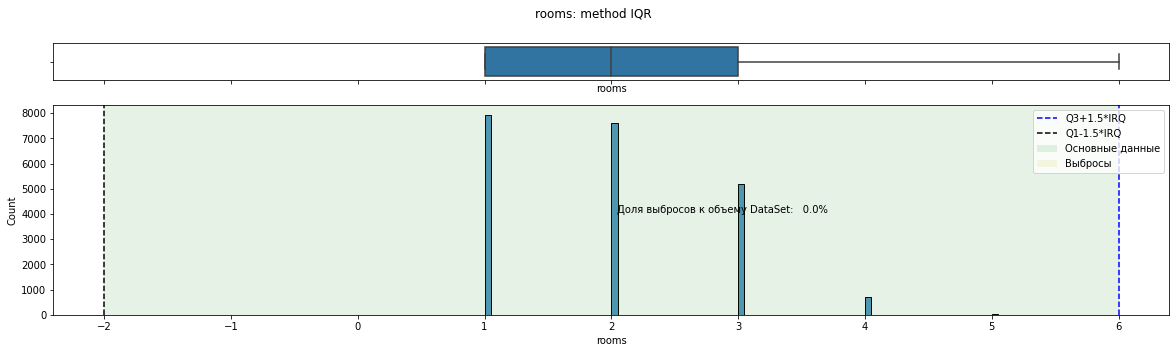

6.0


In [93]:
upper_lim_p = outliers_method(data, 'rooms', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

Имеющиеся данные не требуют дополнительной обработки, хотя 6 комнат по 8.5 квадратных метров выглядет странно - вполне возможно переделанная квартира с открытой планировкой.

**Столбец "last_price"**

In [94]:
data['last_price'].describe()

count    21530.000000
mean      5141.466716
std       3056.464567
min        430.000000
25%       3350.000000
50%       4490.000000
75%       6110.000000
max      53000.000000
Name: last_price, dtype: float64

In [95]:
data.loc[data['last_price']<500, 'locality_name']

5698      п.г.т. Будогощь
6859        д. Старополье
9581        д. Старополье
10782              Сланцы
14911    п. станции Свирь
16032              Сланцы
16219     д. Вахнова Кара
16274       д. Старополье
17456              Сланцы
17676        д. Ям-Тесово
18867         д. Выскатка
21912        п. Совхозный
23484              Сланцы
Name: locality_name, dtype: object

Низкие цены за квартиру объясняются значительной удаленностью от города Санкт-Петербурга, и тем что жилье располагается в деревням. Такое вполне возможно.

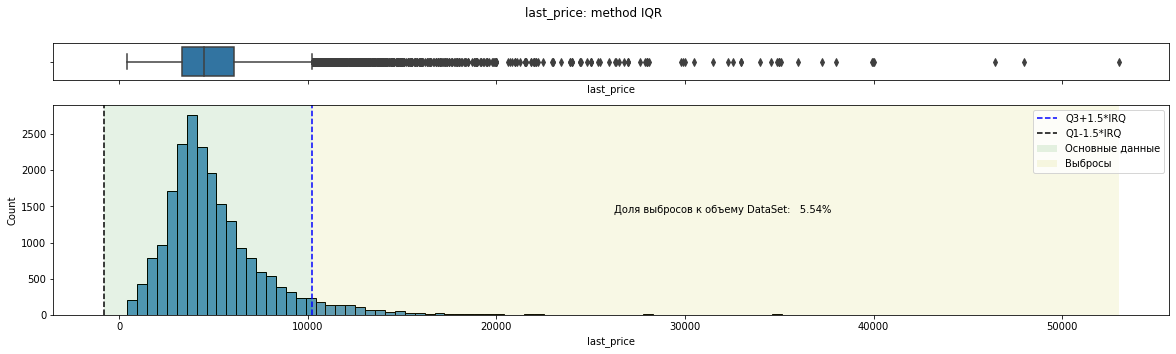

10250.0


In [96]:
upper_lim_p = outliers_method(data, 'last_price', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

In [97]:
data.loc[data['last_price']>10250].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,price_per_meter,day_of_publication,month_of_publication,year_of_publication,type_of_floor,type_of_floor_num,center_city_dist_in_km,z_score,area_per_room
81,9,10949.0,68.0,2018-12-27,1,2.65,10.0,17.6,6,False,...,<NA>,161.014706,3,12,2018,other,1,NaN,1.900082,17.600000
98,11,11700.0,80.0,2014-12-10,3,2.65,5.0,55.1,3,False,...,831,146.250000,2,12,2014,other,1,9.0,2.145791,18.366667
107,1,11000.0,101.0,2016-04-13,4,3.00,3.0,73.0,3,False,...,122,108.910891,2,4,2016,last,2,33.0,1.916768,18.250000
116,18,10999.0,97.2,2017-11-13,3,2.50,16.0,45.0,16,False,...,394,113.158436,0,11,2017,last,2,21.0,1.916441,15.000000
140,8,16912.0,105.7,2016-12-09,2,2.70,3.0,48.4,1,False,...,390,160.000000,4,12,2016,first,0,27.0,3.851029,24.200000
156,11,10990.0,80.0,2018-06-25,2,2.75,22.0,34.0,19,False,...,7,137.375000,0,6,2018,other,1,15.0,1.913496,17.000000
173,15,11000.0,97.9,2017-04-11,3,2.75,16.0,57.7,3,False,...,<NA>,112.359551,1,4,2017,other,1,13.0,1.916768,19.233333
179,5,14800.0,108.7,2019-04-11,3,4.00,5.0,72.4,5,False,...,<NA>,136.154554,3,4,2019,last,2,3.0,3.160034,24.133333
186,12,11640.0,65.2,2018-10-02,2,2.65,9.0,30.8,4,False,...,49,178.527607,1,10,2018,other,1,12.0,2.126160,15.400000
260,8,17250.0,102.4,2014-12-09,3,2.65,8.0,53.2,3,False,...,<NA>,168.457031,1,12,2014,other,1,11.0,3.961614,17.733333


Здесь встречаются вполне нормальные варианты квартир, попробуем отбросить значения с помощью метода z-score.

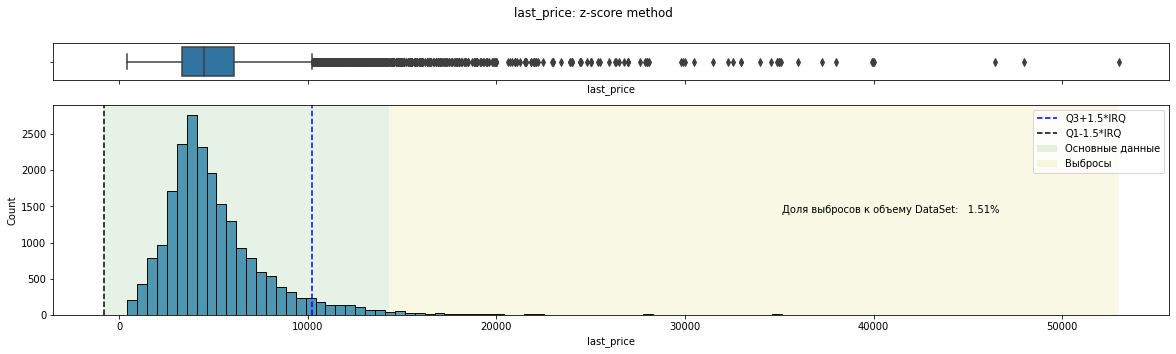

14300.0


In [98]:
upper_lim_z = outliers_method(data, 'last_price', 'z-score') # iqr,  percentiles, z-score methods for labl
print(upper_lim_z)

Будем считать, что в выборку попали квартиры с ценой меньше 15 млн. рублей 

In [99]:
data = data[data['last_price']<=upper_lim_z]

In [100]:
data.shape[0]

21205

**Столбец "ceiling_height"**

In [101]:
data['ceiling_height'].describe()

count    21205.000000
mean         2.696397
std          0.772163
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

'Сегодня минимальной нормой в России считается высота потолка 2.4 метра' - где вто в интернете написано(не один раз). Значит все что меньше - выбросы. В столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Логично. Обработаем эти данные.

In [102]:
data.loc[data['ceiling_height']>=24, 'ceiling_height'] = data['ceiling_height']/10

In [103]:
data = data[data['ceiling_height']>=2.4]

In [104]:
data['ceiling_height'].describe()

count    21184.000000
mean         2.675614
std          0.281235
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max         22.600000
Name: ceiling_height, dtype: float64

Максимальное значение высоты потолка все равно осталось 22.6. Избавимся от выбросов

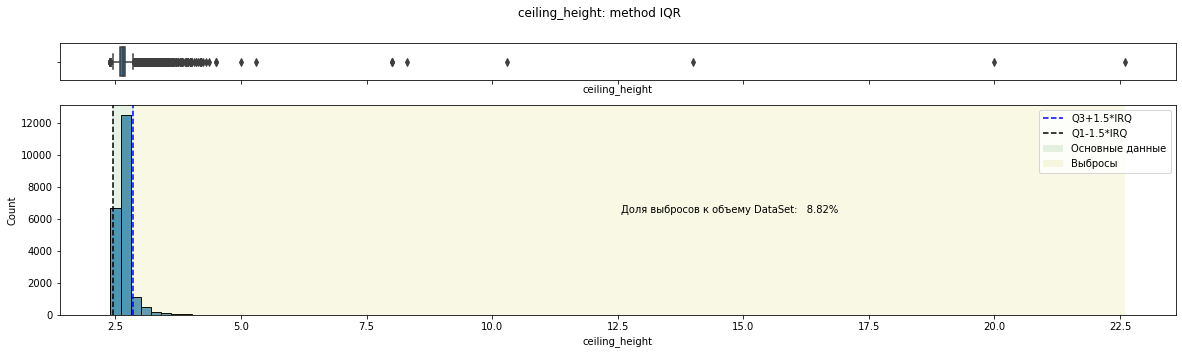

2.8500000000000005


In [105]:
upper_lim_p = outliers_method(data, 'ceiling_height', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

Получилось очень радикально, потому что даже в современной застройке встречаются потолки 3.3 метра(и в дореволюционной). Попробуем метод z-score

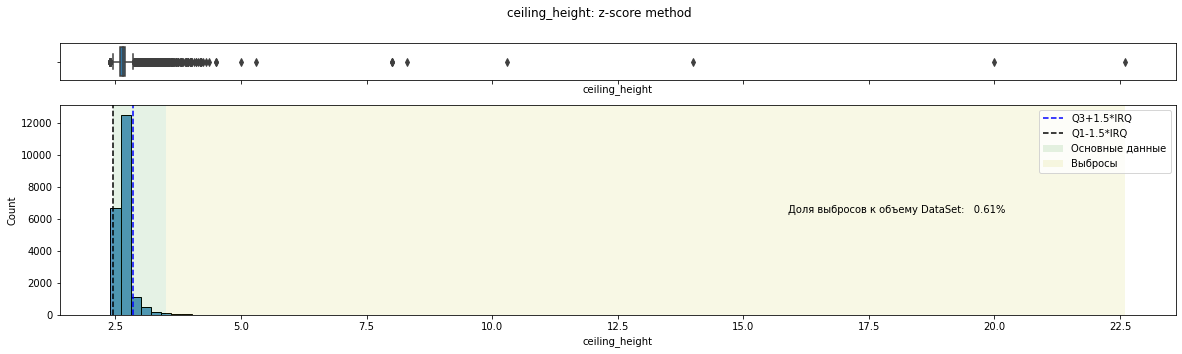

3.5


In [106]:
upper_lim_z = outliers_method(data, 'ceiling_height', 'z-score') # iqr,  percentiles, z-score methods for labl
print(upper_lim_z)

Ограничимся высотой 3.5 метра. Будем считать что все остальное скорее всего пентхаусы и элитное жилье.

In [107]:
data = data[data['ceiling_height']<=upper_lim_z]

In [108]:
data.shape[0]

21055

**Столбец "type_of_floor"** 

In [109]:
pie_chart =data.pivot_table(index='type_of_floor', values='type_of_floor_num', aggfunc='count')
pie_chart

,type_of_floor_num
type_of_floor,
first,2687
last,2911
other,15457


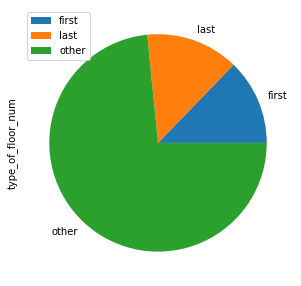

In [110]:
pie_chart.plot(y= 'type_of_floor_num',  kind="pie", figsize=(10,5));

Вполне логично, что первых и последний этажей примерно поровну.

**Столбец "floors_total"** 

In [111]:
data['floors_total'].describe()

count    21054.000000
mean        10.791869
std          6.599609
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

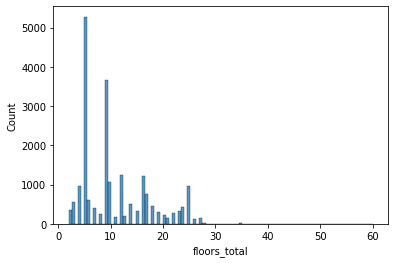

In [112]:
sns.histplot(data = data[data['floors_total']>1], x = 'floors_total', bins=100); 

Скорее всего 60-этажное здание это выброс. Попробуем его отбросить.

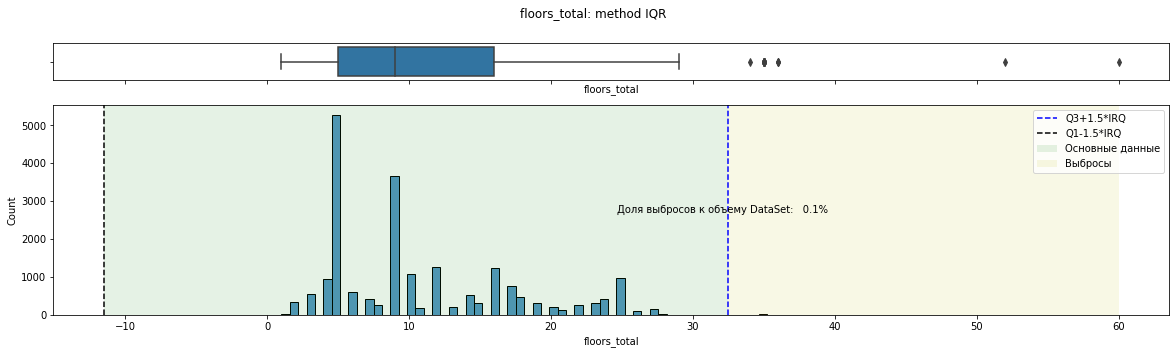

32.5


In [113]:
upper_lim_p = outliers_method(data, 'floors_total', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

В домах с 35 этажами есть 16 квартир с неплохими данными, оставим их в рассмотрении

In [114]:
data = data[data['floors_total']<=upper_lim_p]

In [115]:
data.shape[0]

21032

**Столбец "citycenters_nearest"** 

In [116]:
data["citycenters_nearest"].describe()

count    16322.000000
mean     15243.121462
std       8451.488415
min        287.000000
25%      10793.750000
50%      13842.000000
75%      17121.000000
max      65968.000000
Name: citycenters_nearest, dtype: float64

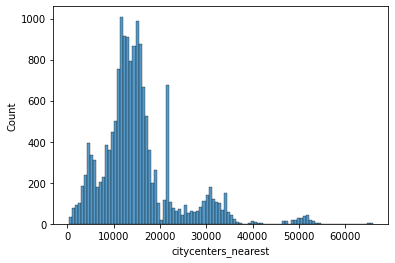

In [117]:
sns.histplot(data = data[data['citycenters_nearest']>1], x = 'citycenters_nearest', bins=100); 

In [118]:
data.loc[data['citycenters_nearest']>55000, 'locality_name']

577      п. Молодежное
939        Зеленогорск
2974       Зеленогорск
4441       Зеленогорск
5218     п. Молодежное
5340     п. Молодежное
9640     п. Молодежное
11244      Зеленогорск
16569        Ломоносов
18884      Зеленогорск
20746    п. Молодежное
23123        Ломоносов
Name: locality_name, dtype: object

Данные группируются относительно расположения населенных пунктов(отдельные локаьлные максимумы количества объявления в хвосте диаграммы) и нет смысл их выбрасывать, так как тогда придется не рассматривать место полностью. С учетом того, что есть еще объявления, где расстояние до центра города не указано.

**Столбец "parks_nearest"** 

In [119]:
data["parks_nearest"].describe()

count    6585.000000
mean      490.159605
std       331.857645
min         1.000000
25%       292.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

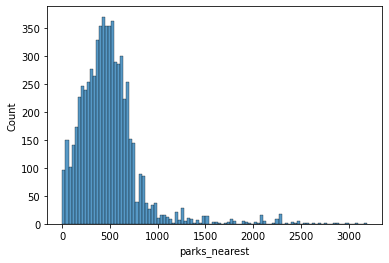

In [120]:
sns.histplot(data = data, x = 'parks_nearest', bins=100); 

Тут нет смысла что-либо менять, потому что скорее всего в объявлениях будут смотреть на категориальный признак "наличие парка" рядом с объектом недвижимости. И в нем были бы значения 1: парк ближе 1 км., 0Ж парков нет, или они дальше. Можно внести его в общую таблицу.

In [121]:
def part_is_here (row):
    if row['parks_nearest'] <= 1000:
        return  True
    else:                            # там где то затесался NaN  и тогда его нет точно
        return False 

In [122]:
data['is_park'] = data.apply(part_is_here, axis=1)

In [123]:
data['is_park'].head(5)

1    False
2     True
5    False
6    False
7    False
Name: is_park, dtype: bool

**Итог:** 

In [124]:
(size_of_data-data.shape[0])/size_of_data*100

11.25363939406726

Удалось избавиться от выбросов и нереалистичных значений в ячейках таблицы. Общая потеря данных составила 11%. В основном "порезали" на площади квартир, используя более слабый фильтр, можно было бы несколько сократить эту величину.

**0.4.2 Изучите, как быстро продавались квартиры (столбец days_exposition)(по заданию)**

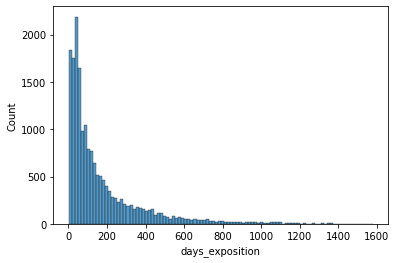

In [125]:
sns.histplot(data = data, x = 'days_exposition', bins=100); 

In [126]:
data['days_exposition'].describe()

count       18451.0
mean     173.138692
std      211.184099
min             1.0
25%            44.0
50%            92.0
75%           219.0
max          1580.0
Name: days_exposition, dtype: Float64

Распределение близко к распределению Пуассона. Среднее значение 173 сильно отличается от меридианного 92 и смещено вправо, что объясняется выбросам с анномально долгими сроками продачи квартир. Для того, чтобы посмотреть предел, когда продажи могут считаться необычно длинными, можно использовать ранее написанную функцию для IQR.

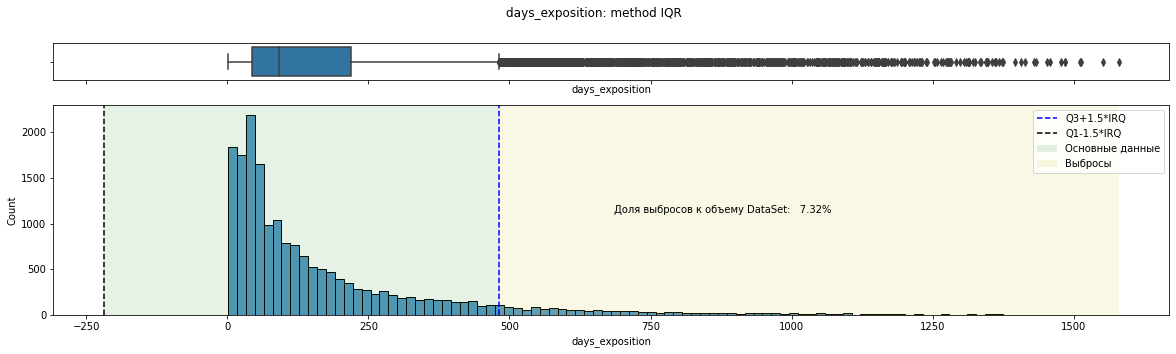

481.5


In [127]:
upper_lim_p = outliers_method(data, 'days_exposition', 'iqr') # iqr,  percentiles, z-score methods for labl
print(upper_lim_p)

Таким образом, верхний предел допустимых сроков продажи квартир составляет порядка 482 дней. И порядка 7 % квартир не были проданы к этому времени.

In [128]:
data['days_exposition'].isna().sum()

2581

Оставшиеся 2581 квартир не имею данных о времени продажи и разделяются на непроданные квартиры и квартиры сосредоточенные в населенных пунктах, где вообще нет такой информации - они так же могут быть не проданными, либо какой то иной фактор имеет место быть

В итоге:
- быстрые продажи: до 92 дней;
- медленные продаже: от 92 до 482 дней;
- аномально долгие: более 482 дней.

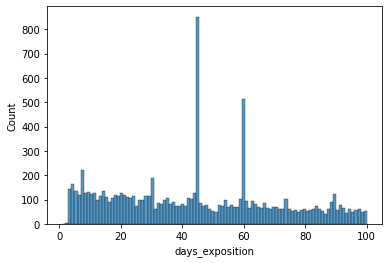

In [129]:
sns.histplot(data = data.loc[data['days_exposition']<=100],  x = 'days_exposition', bins = 100);

**0.4.3 Какие факторы больше всего влияют на полную стоимость объекта: общая площадь, жилая площадь, площадь кухни, количества комнат, этажа(первый, последний, другой), даты размещения (день недели, месяц, год) ?**

**Обработаем признаки: общая площадь, жилая площадь, площадь кухни, количества комнат, вместе.** 

In [130]:
cols = ['last_price' ,'total_area', 'living_area', 'kitchen_area', 'rooms']

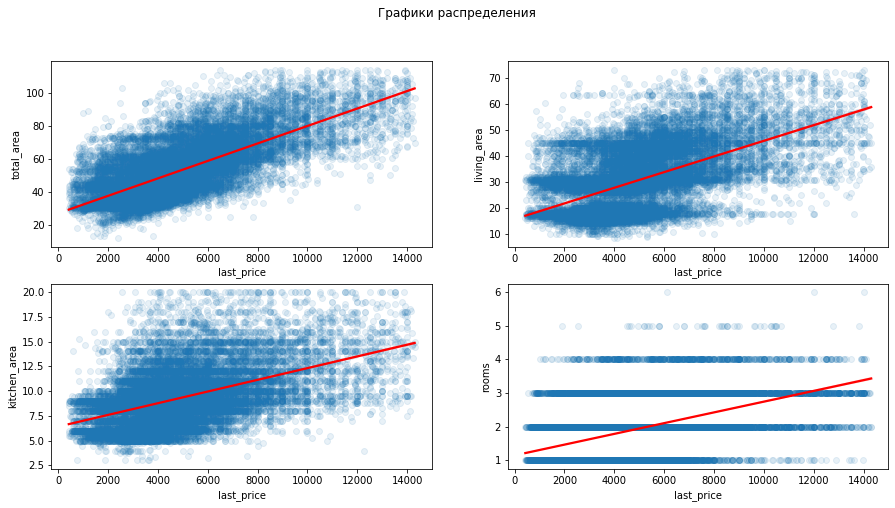

In [131]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7.5))
fig.suptitle('Графики распределения')
sns.regplot(x='last_price', y='total_area', data=data, ax = ax[0][0], scatter_kws = {'alpha': 0.1}, line_kws={'color':'red'});
sns.regplot(x='last_price', y='living_area', data=data, ax=ax[0][1], scatter_kws = {'alpha': 0.1}, line_kws={'color':'red'});
sns.regplot(x='last_price', y='kitchen_area', data=data, ax=ax[1][0],  scatter_kws = {'alpha': 0.1}, line_kws={'color':'red'});
sns.regplot(x='last_price', y='rooms', data=data,  ax=ax[1][1], scatter_kws = {'alpha': 0.1}, line_kws={'color':'red'});
plt.show()
# plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}

Наблюдается прямая зависимость цены от общей площади, площади жилого помещения, площади кухни и количества комнат. Количественно оценить степень зависимости можно на основании регрессионного анализа.

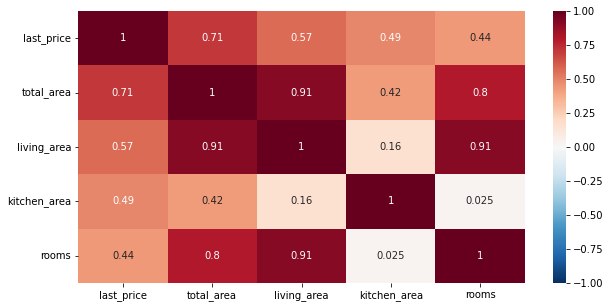

In [132]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    data[cols].corr(),        
    cmap='RdBu_r',                # задаёт цветовую схему
    annot=True,                   # рисует значения внутри ячеек
    vmin=-1, vmax=1              # указывает начало цветовых кодов от -1 до 1.
);

Коэффициенты корреляции приведены в первом столбце тепловой диаграммы. Самая сильная зависимость стоимость квартиры от общей площади (0.71), далее по ниспадающей: площадь жилых помещений (0.57), площадь кухни (0.49) и количество комнат (0.44).

**Влияние этажности квартиры** 

Здесь и далее обойдемся графиками, так как нам нужно просто установиться наличие некой динамики, а не получить ее количественную оценку (сначала в предыдущем параграфе сделал, но все было практически ноль, а место и время занимало)

Вообще лучше смотреть цену квадратного метра от этажности, вместо цены квартиры:

In [133]:
floorness = data.pivot_table(index='type_of_floor', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
floorness.columns = ['type_of_floor', 'median', 'count']
floorness

,type_of_floor,median,count
0,first,80.392157,2687
1,last,84.684685,2911
2,other,96.417835,15434


Построим лепестковую диаграмму для наглядности

In [134]:
def diag_plotter(df, tg_column, not_column, ax):
    N = df.shape[0]
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False) 
    theta = np.append(theta, theta[:1])
    radii = df[tg_column].values
    radii = np.append(radii, radii[:1])
    ax.set(xticks=theta[:-1], xticklabels=df[not_column], title =tg_column, ylim =(0,1.15*max(radii)))
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=14, colors='gray')
    ax.plot(theta, radii, linewidth=1, linestyle='solid')
    ax.fill(theta, radii, 'b', alpha=0.1)
    theta1 = np.linspace(0, 2 * np.pi, 250, endpoint=False) 
    theta1 = np.append(theta1, theta1[:-1])
    mid_val = (df[tg_column]*df['count']).sum()/(df['count'].sum())
    radii1 = mid_val*np.ones(250)
    radii1 = np.append(radii1, radii1[:-1])
    ax.plot(theta1, radii1, linewidth=1, linestyle='--', label="Средняя значение параметра: "+ str(round(mid_val)) ,  color="r")
    ax.fill(theta1, radii1, "#3CB371", alpha=0.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.75, -0.01))   

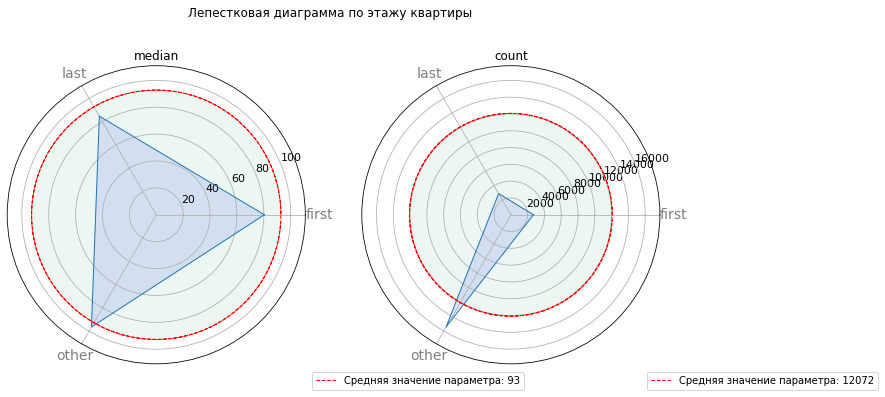

In [135]:
fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по этажу квартиры',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(floorness, "median", 'type_of_floor', ax1)
diag_plotter(floorness, "count", 'type_of_floor', ax2)
plt.show()

Результат ожидаемый, больше ценится жилье на средних этажах, немного меньше на последних и меньше всего на первых. И объявлений значительно больше

**Влияние даты размещения (день недели, месяц, год)** 

In [136]:
dayness = data.pivot_table(index='day_of_publication', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
dayness.columns = ['day_of_publication', 'median', 'count']
dayness

,day_of_publication,median,count
0,0,92.731488,3218
1,1,93.478261,3719
2,2,93.556688,3510
3,3,92.982456,3767
4,4,92.500000,3543
5,5,91.578947,1743
6,6,92.888748,1532


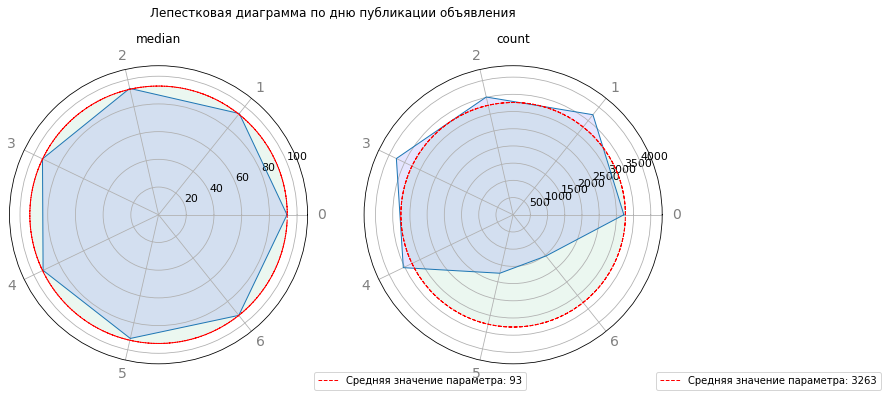

In [137]:
fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по дню публикации объявления',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(dayness, "median", 'day_of_publication', ax1)
diag_plotter(dayness, "count", 'day_of_publication', ax2)
plt.show()

Цена практически не зависит от дня публикации, а вот количество размещенных объявлений в выходные значительно ниже. Вторник, Четверг и Пятница самые богатые на публикации.

In [138]:
montness = data.pivot_table(index='month_of_publication', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
montness.columns = ['month_of_publication', 'median', 'count']

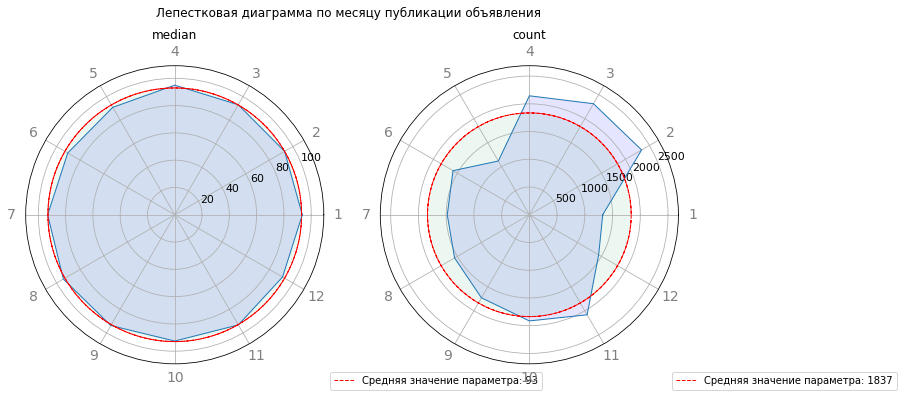

In [139]:
fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по месяцу публикации объявления',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(montness, "median", 'month_of_publication', ax1)
diag_plotter(montness, "count", 'month_of_publication', ax2)
plt.show()

Месяц публикации на цену не влияет. A по количеству публикаций, интересно, что самые активные месяца - февраль, март и апрель, в осеннее время так же наблюдается всплеск объявлений. Май - люди готовятся к лету и отпуску и тратят вероятно на другое, летом(июня, июль, август) - затишье. Декабрь и январь - новый год.

In [140]:
yearness = data.pivot_table(index='year_of_publication', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
yearness.columns = ['year_of_publication', 'median', 'count']

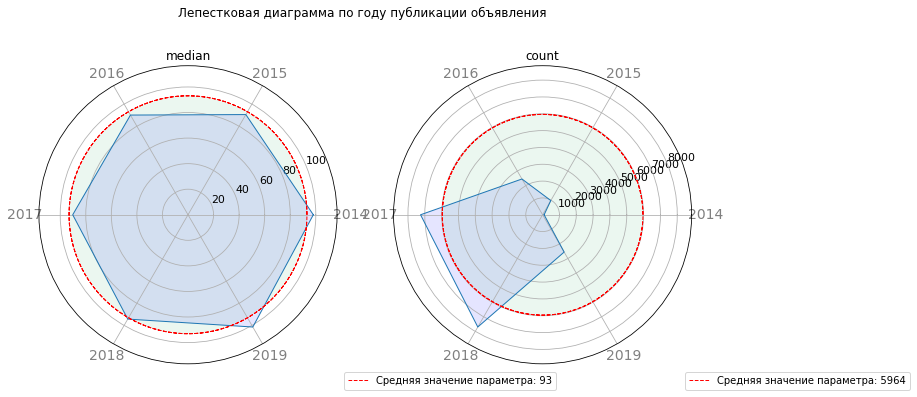

In [141]:
fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по году публикации объявления',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(yearness, "median", 'year_of_publication', ax1)
diag_plotter(yearness, "count", 'year_of_publication', ax2)
plt.show()

Видно, что с каждым годом (после 2014) наблюдается рост цены квадратного метра жилья. Можно было бы построить корреляцию между этими факторами, но в действительности большой объем объявлений представлен только за 2017 и 2018 годы.

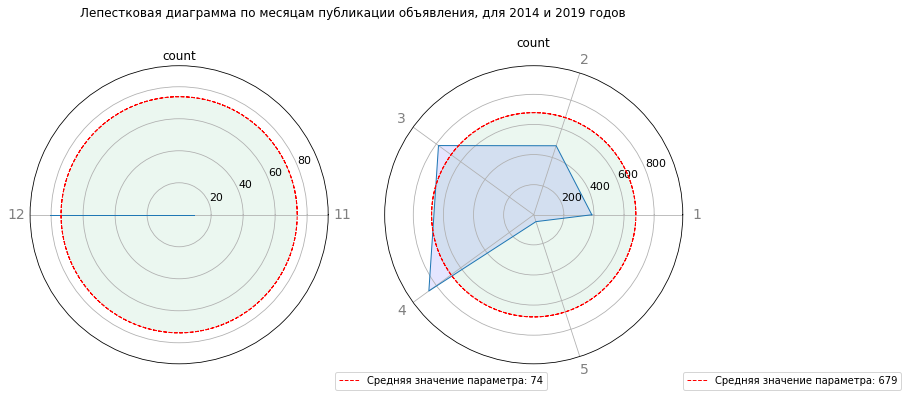

In [142]:
montness2019 = data.loc[data['year_of_publication']==2019].pivot_table(index='month_of_publication', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
montness2019.columns = ['month_of_publication', 'median', 'count']
montness2014 = data.loc[data['year_of_publication']==2014].pivot_table(index='month_of_publication', values='price_per_meter', aggfunc=['median', 'count']).reset_index()
montness2014.columns = ['month_of_publication', 'median', 'count']

fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по месяцам публикации объявления, для 2014 и 2019 годов',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(montness2014, "count", 'month_of_publication', ax1)
diag_plotter(montness2019, "count", 'month_of_publication', ax2)
plt.show()

То еть в 2014 году объявления в базе появились только с ноября, а в 2019 последние объявления датированы маем месяцем.

**0.4.4 Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [143]:
top_places = data.pivot_table(index='locality_name', values=['price_per_meter'], aggfunc=['mean', 'count']).reset_index()
top_places.columns = ['locality_name', 'price_per_meter', 'count']
top_places = top_places.sort_values(by = 'count', ascending=False).reset_index(drop=True)
top_places.head(10)

,locality_name,price_per_meter,count
0,Санкт-Петербург,106.572382,13431
1,п. Мурино,84.968351,523
2,п. Шушары,78.403548,426
3,Всеволожск,66.904234,378
4,Колпино,75.408472,331
5,Пушкин,100.390639,326
6,п. Парголово,90.380299,318
7,Гатчина,69.052008,299
8,д. Кудрово,92.636579,266
9,Выборг,58.278294,218


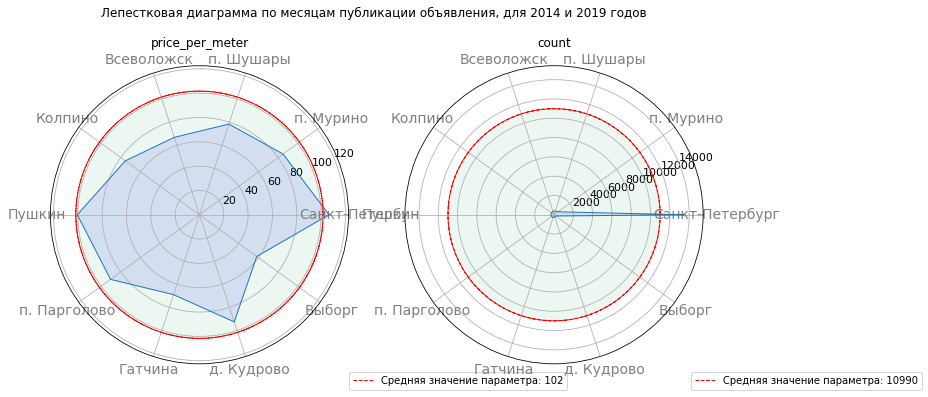

In [144]:
fig, [ax1, ax2] = plt.subplots(1, 2, subplot_kw=dict(projection='polar'),  figsize = (10,8))
fig.suptitle('Лепестковая диаграмма по месяцам публикации объявления, для 2014 и 2019 годов',x=0.5, y=0.83)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
diag_plotter(top_places[0:10], "price_per_meter", 'locality_name', ax1)
diag_plotter(top_places[0:10], "count", 'locality_name', ax2)
plt.show()

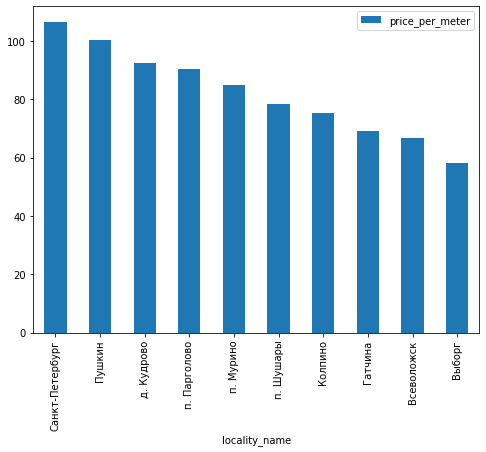

In [145]:
(top_places[0:10].sort_values(by ='price_per_meter', ascending=False)
                 .plot(x='locality_name', y='price_per_meter', kind='bar', figsize=(8,6)) );

Медианная цена за квадратный метр в 10 самых представленных в таблице населенных пунктах составила 99 тыс. рублей. Самая дорогая недвижимость находиться в Санкт-Петербурге(только здесь средняя цена выше средней по выборке) и далее по убыванию: Пушкин, д. Кудрово, п. Парголово, п. Мурино, п. Шушары, Колпино, Всеволжск, Гатчина, Выборг. В Петербурге принципиально больше выставленных объявлений.

**0.4.5 Выделить квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра**

In [146]:
only_city = (data.loc[data['locality_name']=='Санкт-Петербург', ['locality_name', 'price_per_meter' ,'center_city_dist_in_km']]
            .sort_values(by = 'center_city_dist_in_km')
            .reset_index(drop=True)
            )

In [147]:
only_city.head(5)

,locality_name,price_per_meter,center_city_dist_in_km
0,Санкт-Петербург,100.000000,0.0
1,Санкт-Петербург,144.957983,0.0
2,Санкт-Петербург,139.318885,0.0
3,Санкт-Петербург,108.163265,0.0
4,Санкт-Петербург,75.471698,0.0


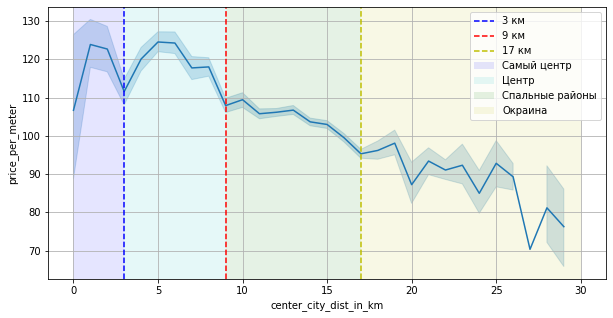

In [148]:
plt.figure(figsize=(10,5))
sns.lineplot(data=only_city, y="price_per_meter", x="center_city_dist_in_km", markers=True, dashes=True)
plt.axvline(x = 3, color = 'b', linestyle='dashed', label = '3 км')
plt.axvline(x = 9, color = 'r', linestyle='dashed', label = '9 км')
plt.axvline(x = 17, color = 'y', linestyle='dashed', label = '17 км')

plt.axvspan(0, 3, facecolor='b', alpha=0.1, label = 'Самый центр')
plt.axvspan(3, 9, facecolor='c', alpha=0.1, label = 'Центр')
plt.axvspan(9, 17, facecolor='g', alpha=0.1, label = 'Спальные районы')
plt.axvspan(17, 30, facecolor='y', alpha=0.1, label = 'Окраина')
plt.grid()
plt.legend();

Там где есть экстремумы или поведение графика меняется, скорее всего происходит изменение типа района. До трех километров очень похоже на историческую часть города, далее до 7 км - центральная часть, равномерное падение цены от расстояния характеризует спальную застройку. Увеличение неравномерности это периферия, где велико влияние конкретного места, транспортной доступности и застройки жилыми кварталами (ну и я карту открыл города, так наверное и есть 🤪 )

### Общие выводы

* Изучение данных из файла
    * Общее количество строк составляет `23699`, во всех столбцах, кроме `total_images`, `last_price`, `total_area`, `first_day_exposition`, `rooms`, `floor`, `studio`, `open_plan`, имеются пропуски.
    * Должно быть 3 столбца с булевыми значениями: `is_apartment`, `open_plan`, `studio`, однако `is_apartment` имеет тип `object`.
    * Необходимо преобразовать значения столбца `first_day_exposition` в формат дата-время с помощью метода `to_datetime()`.
    * Видно, что есть объекты с количеством комнат, равным `0` - скорее всего это студии. Также есть объекты, с числом комнат - `19`.
    * Стандартное отклонение во всех столбцах велико и говорит о неоднородности данных и большом количестве пропусков.
    * Максимальное значение высоты потолков - `100 м`, это явная аномалия (даже после деления на 10).
    * Есть квартира с общей площадью `900 м2`, кухней `112 м2` и жилой площадью `409.7 м2`.
    * Дубликатов нет, но есть объявления о повторной продаже квартир.
    * Порядка 20 % данных незаполнено.
    
* Предобработка данных

    * В зависимости от дальнейшей работы с таблицей можно как оставить незаполненные ячейки, так и постараться их заполнить с использованием медианных значений в столбцах в соответствии с географических  месторасположением (логичнее всего).
    * По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. Соответственно, пропуски в столбцах `ceiling_height` `living_area` `is_apartment` `kitchen_area` `balcony` могли возникнуть по нескольким причинам: не были вписаны пользоателями либо потерялись при преобразовании форматов. Остальные столбцы были получены автоматически на основе картографических данных и пропуски могут быть вызваны сбоем при выгрузке картографических данных, либо отсутствием парков и прудов в маленьких населенных пунктах.
    * Преобразован тип данных в столбце `first_day_exposition` в тип `datetime`.
    * Для удобства восприятия цены, она конвертирована в тыс. рублей.
    * Устранены дубликаты в названиях населенных пунктов, систематизированы и введены сокращения в классах населенных пунктов.
    * Преобразован тип данных в столбце `is_apartment` в тип `bool`, NaN заполнено как `False`.
    * Пропуски в столбце `balcony` заменены нулями, значение переведено в тип `bool`.
    * Заполнены значения в графах `parks_around3000`, если парка нет на расстоянии 3000 м - в графе `parks_nearest`.
    * Заполнены значения в графах `ponds_around3000`, если парка нет на расстоянии 3000 м - в графе `ponds_neares`.
    * Пропуски в `floors_total` заполнены на основании этажности в конкретном населенном пунке.
    * Заполнение по средним значениям в конкретном населенном пункте использовалась и далее для `airports_nearest`, `citycenters_nearest`, 
    * Содержащиеся в столбце `days_exposition` NaN означают, что объект недвижимости не был продан, а следовательно не нуждаются в заполнении.
    * Пропуски в `ceiling_height` на оновании медианный значений.
    * Пропуски в столбцах `living_area`, `kitchen_area` и `studio` заполнены на основании средних значений и количества комнат в квартире.
    * Доля пропусков сокращена до 7.7% процента.
      
  
* Расчёты и добавление результатов в таблицу

    * цена квадратного метра рассчитана и добавлена в столбец `price_per_meter`;
    * день недели, месяц и год публикации объявления - добавлены столбцы `day_of_publication` `month_of_publication` `year_of_publication`;
    * этаж квартиры; варианты — первый, последний, другой - добавлены в столбцы `type_of_floor` и `type_of_floor_num`;
    * добавлен столбец расстояния до центра города в км. - `center_city_dist_in_km`
    * добавлен столбец `z_score` для расчета выбросов по методу Z-SCORE.
    * добавлен столбец `area_per_room` для расчета средней площади комнаты.
    * добавлен столбец с признаком наличия парка в радиусе 1 км. - `is_park`.
      
* Исследовательский анализ данных

    * Изучены и обработаны аномалии для: `total_area`, `living_area`, `kitchen_area`, `last_price`, `rooms`, `ceiling_height`, `type_of_floor`, `floors_total`, `citycenters_nearest`, `parks_nearest`
      
        * Использован критерия по IQR, а для случаев когда выбраков слишком велика использовался z-scope метод.
        * Суммарная доля выбросов составила 11 %.
        * В основном сокращения выполнены за счет площади квартир, используя более слабый фильтр, можно было бы несколько сократить выбраковку.
   * Какие факторы больше всего влияют на стоимость квартиры
     
        * С ростом общей площади растет и стоимость. 
        * Самая сильная зависимость стоимость квартиры от общей площади (0.71), далее по ниспадающей: площадь жилых помещений (0.57), площадь кухни (0.49) и количество комнат (0.44). 
        * С удалением от центра цена объекта снижается. 
        * Первый этаж характеризуется минимальной величиной медианной стоимости, стоимость квартир на последнем этаже несколько ниже стоимости квартир на этажах типа "другой", однако больше, чем стоимость квартир на первом этаже. Цена квадратного метра для квартир на первом этаже минимальная, максимальная - для квартир на этаже "другой". 
        * Взаимосвязи стоимости с днем недели, месяцем и годом не наблюдается, но есть взаимосвязь по количеству опубликованных объявлений (выходные-"выходные").
        * Таблица основана в основном на данных за 2018 и 2017 годы.
        * Изучено время продажи квартиры. Построена гистограмма. Рассчитаны среднее и медиана. Обычно продажа занимает до 200-481 дней - т.е. за полгода-год. Можно считать, что быстрая продажа - это та, которая заняла 92 дней, медленная - более 92 дней. Необычно долгие продажи - более 481 дней.
        * На 45 и 60 день бесплатные объявления снимаются с рассмотрения, необходимо запросить дополнительные данные у сервиса продажи квартир и в дальнейшем предусмотреть специальную маркировку таких объявлений. 
        * Выбраны 10 населённых пунктов с наибольшим числом объявлений. 
        * Согласно полученным данным, видно, что максимальное количество объявлений соответствует г. Санкт-Петербург, далее по убыванию располагаются посёлок Мурино, посёлок Шушары, Всеволожск, Пушкин, Колпино, Гатчина, посёлок Парголово, деревня Кудрово и Выборг. Минимальная средняя цена квадратного метра составляет 58 тыс. рублей и соответствует Выборгу, максимальная - Санкт-Петербургу и составляет 106 тыс.рублей.
        * Выделены квартиры в Санкт-Петербурге (locality_name). Получен график зависимости цены квадратного метра от удаленности от центра в км. Согласно графику получен радиус цнтральной зоны - 7 км(более подробно - смотри график).


- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод